In [17]:
# Utility Libraries
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import sys
from collections import OrderedDict
import time
import random
from scipy import linalg
import cv2
from PIL import Image

# Pytorch relevant librariesa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cat
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torchvision.models import inception_v3

# Plotting Libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
with open('/kaggle/input/iam-handwriting-word-database/iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents]

In [20]:
file_names = []
texts = []

for line in lines:
    file_name = line.split()[0]
    text = line.split()[-1]
    
    file_names.append(file_name)
    texts.append(text)

In [21]:
words_data = pd.DataFrame()
words_data['file_name'] = file_names
words_data['text'] = texts

In [22]:
words_data

,file_name,text
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.
...,...,...
22516,b06-110-06-07,Rosyth
22517,b06-110-07-00,dockyard
22518,b06-110-07-01,last
22519,b06-110-07-02,year


In [23]:
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

def encode_to_labels(text, max_word_length=17):
    dig_list = []
    for index in range(max_word_length):
        char = 78
        if index < len(text):
            char = char_list.index(text[index])
        dig_list.append(char) 
        
    return dig_list

In [24]:
class IAMDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.data['file_name'][idx]
        text = self.data['text'][idx]

        # Construct file path
        part = file_name.split('-')
        file_name = file_name + '.png'
        file_path = f"{self.root_dir}/{part[0]}/{part[0]}-{part[1]}/{file_name}"

        # Load image
        try:
            image = Image.open(file_path).convert("RGB")
        except:
            image = torch.zeros((1, 32, 128))
            label = torch.zeros((17))
            return image, label


        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(encode_to_labels(text))

        return image, torch.tensor(label)

In [25]:
transform = transforms.Compose([
    transforms.Grayscale(),   
    transforms.Resize((32, 128)),
    transforms.ToTensor()
])

In [26]:
dataset = IAMDataset(data=words_data, root_dir='/kaggle/input/iam-handwriting-word-database/iam_words/words', transform=transform)

In [27]:
batch_size = 128

# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [51]:
torch.save(dataset, 'dataset.pth')

In [30]:
def visualize_image(dataloader):
    for image, label in dataloader:
        break
        
    image = image[0]  # first image
    plt.figure(figsize=(4, 16))
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    label = ''.join([char_list[index] for index in label[0] if index != 78])
    plt.title(f'{label}')
    plt.axis('off')
    plt.show()

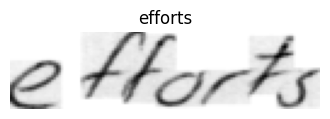

In [31]:
visualize_image(train_loader)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.batch_norm5(x)
        x = F.relu(self.conv6(x))
        x = self.batch_norm6(x)
        x = self.pool6(x)
        x = F.relu(self.conv7(x))
        x = x.squeeze(2)  # Squeeze the height dimension
        x = x.permute(2, 0, 1)  # Reshape for RNN input
        return x

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
print(device)

cuda


In [38]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(1), self.hidden_size).to(device)
        output, _ = self.lstm(x, (h0, c0))
        output = self.fc(output)
        return output

In [39]:
class HandwritingRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(HandwritingRecognitionModel, self).__init__()
        self.cnn = CNN()
        self.rnn = RNN(512, 256, 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.rnn(x)
        return x

In [40]:
num_classes = 79  # 78 characters + 1 for blank
num_epochs = 300
model = HandwritingRecognitionModel(num_classes)

# Loss function
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
T = 31
C = 79
S = 17
S_min = 16

model = model.to(device)
for epoch in range(num_epochs):
    losses = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        N = images.shape[0]
        optimizer.zero_grad()
        outputs = model(images)
        input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
        target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
        loss = criterion(outputs, labels, input_lengths, target_lengths)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} : Loss : {np.round(np.mean(losses), 3)}")

Epoch 1 : Loss : 2.079
Epoch 2 : Loss : 1.701
Epoch 3 : Loss : 1.537
Epoch 4 : Loss : 1.46
Epoch 5 : Loss : 1.1
Epoch 6 : Loss : 0.968
Epoch 7 : Loss : 0.92
Epoch 8 : Loss : 0.892
Epoch 9 : Loss : 0.861
Epoch 10 : Loss : 0.835
Epoch 11 : Loss : 0.807
Epoch 12 : Loss : 0.78
Epoch 13 : Loss : 0.757
Epoch 14 : Loss : 0.73
Epoch 15 : Loss : 0.708
Epoch 16 : Loss : 0.689
Epoch 17 : Loss : 0.659
Epoch 18 : Loss : 0.638
Epoch 19 : Loss : 0.615
Epoch 20 : Loss : 0.594
Epoch 21 : Loss : 0.576
Epoch 22 : Loss : 0.555
Epoch 23 : Loss : 0.533
Epoch 24 : Loss : 0.518
Epoch 25 : Loss : 0.497
Epoch 26 : Loss : 0.473
Epoch 27 : Loss : 0.457
Epoch 28 : Loss : 0.532
Epoch 29 : Loss : 0.465
Epoch 30 : Loss : 0.425
Epoch 31 : Loss : 0.402
Epoch 32 : Loss : 0.376
Epoch 33 : Loss : 0.359
Epoch 34 : Loss : 0.334
Epoch 35 : Loss : 0.317
Epoch 36 : Loss : 0.307
Epoch 37 : Loss : 0.288
Epoch 38 : Loss : 0.272
Epoch 39 : Loss : 0.256
Epoch 40 : Loss : 0.238
Epoch 41 : Loss : 0.229
Epoch 42 : Loss : 0.213
Epoch 4

In [42]:
torch.save(model.state_dict(), 'dl_project_model.pth')

In [43]:
def get_text(sequence):
    text = ""
    for i in sequence:
        i = i.item()
        if i != 78:
            text += char_list[i]
    return text

In [44]:
def ctc_greedy_decode_batch(logits, blank_index=0):
    """
    Greedy decoding for CTC output for a batch of sequences.
    
    Args:
    logits (np.array): Logits from the model, shape (T, batch_size, C),
                       where T is the sequence length, batch_size is the
                       batch size, and C is the number of characters.
    blank_index (int): Index of the blank symbol.
    
    Returns:
    decoded_sequences (list of lists): Decoded sequences of characters for each batch element.
    """
    T, batch_size, C = logits.shape
    decoded_sequences = []

    for b in range(batch_size):
        # Get the logits for the current batch element
        batch_logits = logits[:, b, :]
        
        # Get the index with maximum probability for each timestep
        best_path = np.argmax(batch_logits, axis=1)
        
        # Collapse consecutive duplicates and remove blank symbols
        decoded_sequence = [best_path[0]]
        for i in range(1, len(best_path)):
            if best_path[i] != blank_index and best_path[i] != best_path[i - 1]:
                decoded_sequence.append(best_path[i])
        
        decoded_sequences.append(decoded_sequence)

    output_text = []
    for sequence in decoded_sequences:
        output_text.append(get_text(sequence))
    
    return output_text

In [46]:
decoded_sequences = ctc_greedy_decode_batch(outputs.detach().cpu())

In [47]:
def show_prediction(image, actual_label, model=model):
    image = image.unsqueeze(0).to(device)
    model = model.to(device)
    output = model(image)
    predicted_text = ctc_greedy_decode_batch(output.detach().cpu())[0]
    
    image = image.reshape(32, 128, 1)
    plt.imshow(image.cpu(), cmap='gray')
    plt.axis('off')
    print(f"Actual : {get_text(actual_label)}", end=", ")
    print(f"Predicted : {predicted_text}")
    plt.show()

In [52]:
htr = HandwritingRecognitionModel(num_classes)

htr.load_state_dict(torch.load('/kaggle/input/word-recogniser/word_recognizer.pth'))

<All keys matched successfully>

In [53]:
for images, labels in train_loader:
    break

Actual : ), Predicted : "


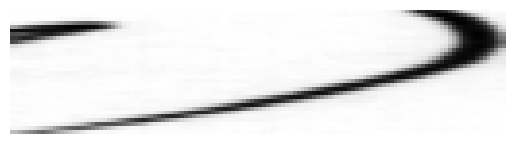

Actual : ), Predicted : "


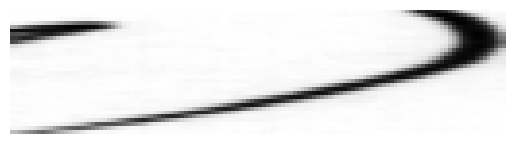

Actual : Commons, Predicted : Commons


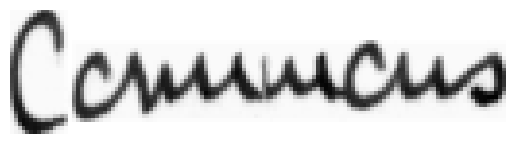

Actual : cities, Predicted : cities


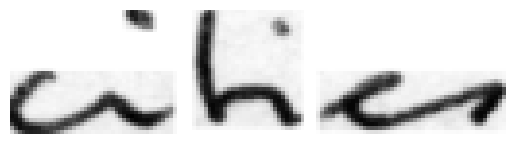

Actual : gathering, Predicted : gathering


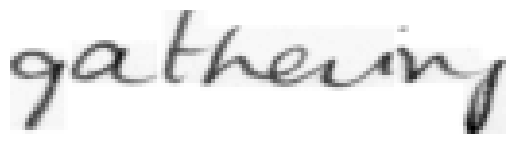

Actual : the, Predicted : the


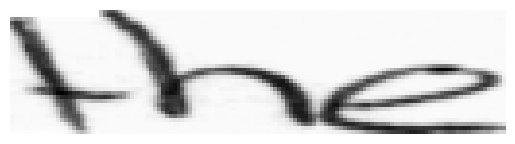

Actual : weaken, Predicted : weaters


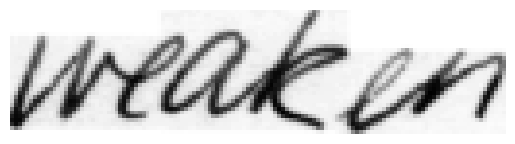

Actual : firm, Predicted : firi


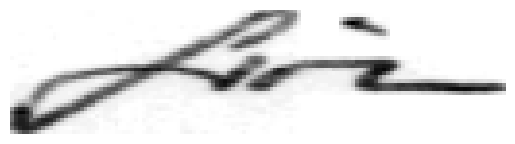

Actual : a, Predicted : a


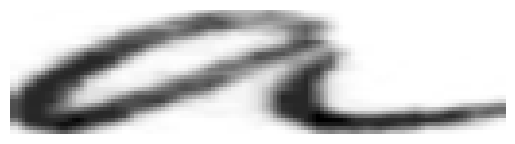

Actual : being, Predicted : being


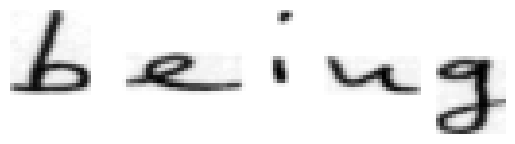

Actual : than, Predicted : than


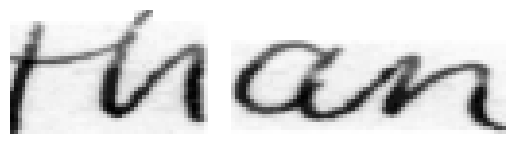

Actual : Rhodesia, Predicted : Rhidei


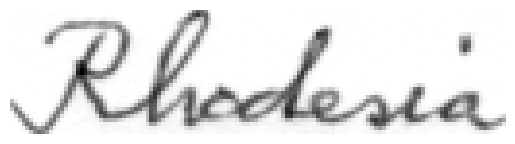

Actual : almost, Predicted : almost


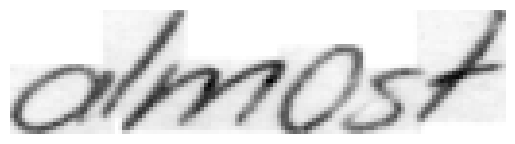

Actual : of, Predicted : of


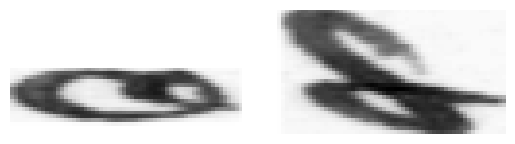

Actual : sub-, Predicted : sub-


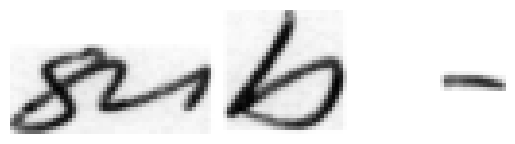

Actual : overdraft, Predicted : overdraft


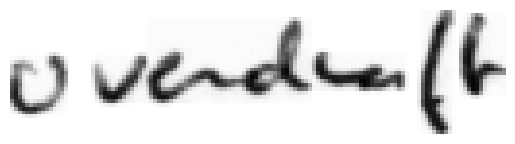

Actual : described, Predicted : dessiled


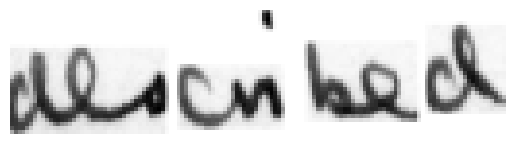

Actual : Sir, Predicted : Sir


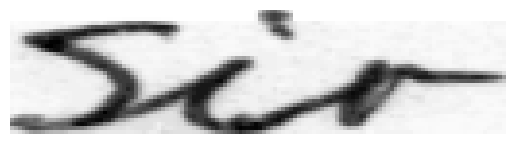

Actual : formula, Predicted : formula


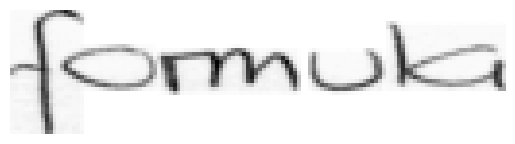

Actual : thinks, Predicted : thines


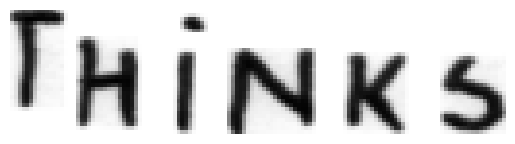

Actual : -, Predicted : ry


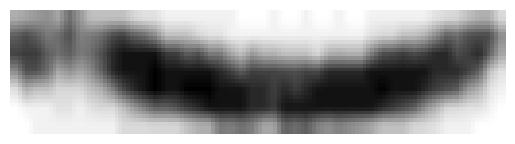

In [54]:
image = images[0]
label = labels[0]

show_prediction(image, label, model=htr)

for i in range(20):
    image = images[i]
    label = labels[i]
    
    show_prediction(image, label, model=htr)